You can run this notebook in a [live session](https://binder.pangeo.io/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/examples/decadal/tropical-pacific-ssts.ipynb) [<img src="https://mybinder.org/badge_logo.svg" alt='binder badge'>](https://binder.pangeo.io/v2/gh/pangeo-data/climpred/main?urlpath=lab/tree/docs/source/examples/decadal/tropical-pacific-ssts.ipynb) or view it [on Github](https://github.com/pangeo-data/climpred/blob/main/docs/source/examples/decadal/tropical-pacific-ssts.ipynb).

# Hindcast Predictions of Equatorial Pacific SSTs

In this example, we evaluate hindcasts (retrospective forecasts) with {py:class}`.HindcastEnsemble` of sea surface temperatures in the eastern equatorial Pacific from CESM-DPLE. These hindcasts are evaluated against a forced ocean-sea ice simulation that initializes the model.

See the [quick start](../quick-start.html) for an analysis of time series (rather than maps) from {py:class}`.HindcastEnsemble`.

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import climpred
from climpred import HindcastEnsemble
import xarray as xr

xr.set_options(display_style="text")

# silence warnings if annoying
# import warnings
# warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

We'll load in a small region of the eastern equatorial Pacific for this analysis example.

In [3]:
initialized = climpred.tutorial.load_dataset("CESM-DP-SST-3D")["SST"]
recon = climpred.tutorial.load_dataset("FOSI-SST-3D")["SST"]
initialized

<xarray.DataArray 'SST' (init: 64, lead: 10, nlat: 37, nlon: 26)>
[615680 values with dtype=float32]
Coordinates:
    TLAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
  * init     (init) float32 1.954e+03 1.955e+03 ... 2.016e+03 2.017e+03
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
    TAREA    (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon

<IPython.core.display.Javascript object>

These two example products cover a small portion of the eastern equatorial Pacific.

It is generally advisable to do all bias correction before instantiating a {py:class}`.HindcastEnsemble`. However, {py:class}`.HindcastEnsemble` can also be modified with {py:meth}`.HindcastEnsemble.remove_bias`.

`climpred` requires that `lead` dimension has an attribute called `units` indicating what time units the `lead` is assocated with.  Options are: `years, seasons, months, weeks, pentads, days`, `hours`, `minutes`, `seconds`.  For the this data, the `lead` `units` are `years`. 

In [4]:
initialized["lead"].attrs["units"] = "years"

<IPython.core.display.Javascript object>

In [5]:
hindcast = HindcastEnsemble(initialized).add_observations(recon)
hindcast

/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(


<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, nlat, nlon) float32 -0.3323 -0.3238 ... 1.179 1.123
Observations:
    SST      (time, nlat, nlon) float32 25.53 25.43 25.35 ... 27.03 27.1 27.05
Uninitialized:
    None

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='validity time', ylabel='SST'>

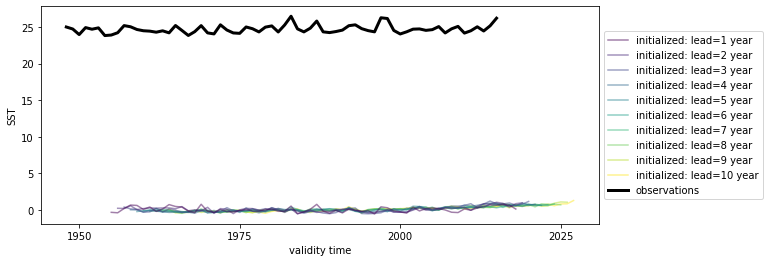

<IPython.core.display.Javascript object>

In [6]:
# Quick look at the HindEnsemble timeseries: only works for 1-dimensional data, therefore take spatial mean
hindcast.mean(["nlat", "nlon"]).plot()

We first need to remove the same climatology that was used to drift-correct the CESM-DPLE.

/Users/aaron.spring/Coding/climpred/climpred/utils.py:191: UserWarning: Assuming annual resolution starting Jan 1st due to numeric inits. Please change ``init`` to a datetime if it is another resolution. We recommend using xr.CFTimeIndex as ``init``, see https://climpred.readthedocs.io/en/stable/setting-up-data.html.
  warnings.warn(


<AxesSubplot:xlabel='validity time', ylabel='SST'>

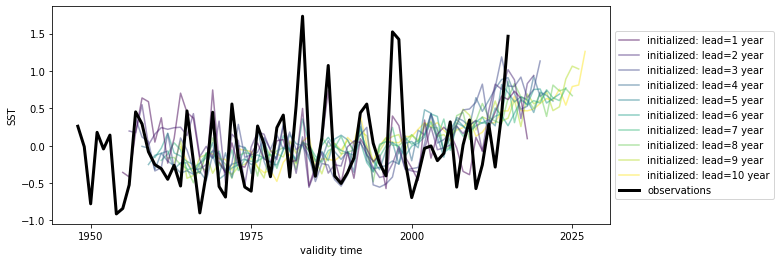

<IPython.core.display.Javascript object>

In [7]:
recon = recon - recon.sel(time=slice(1964, 2014)).mean("time")
hindcast = hindcast.add_observations(recon)
hindcast.mean(["nlat", "nlon"]).plot()

We'll also detrend {py:func}`.climpred.stats.rm_trend` the reconstruction over its `time` dimension and initialized forecast ensemble over `lead`.

In [8]:
from climpred.stats import rm_trend

hindcast_detrend = hindcast.map(rm_trend, dim="lead_or_time")

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='validity time', ylabel='SST'>

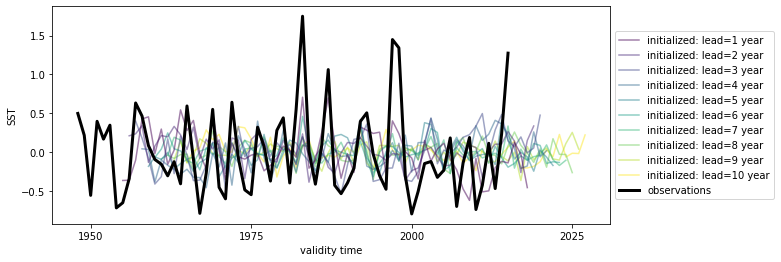

<IPython.core.display.Javascript object>

In [9]:
hindcast_detrend.mean(["nlat", "nlon"]).plot()

## Anomaly Correlation Coefficient of SSTs

We can now compute the ACC {py:func}`.climpred.metrics._pearson_r` over all leads and all grid cells with {py:class}`.HindcastEnsemble.verify`.

In [10]:
predictability = hindcast_detrend.verify(
    metric="acc", comparison="e2o", dim="init", alignment="same_verif"
)
predictability

<xarray.Dataset>
Dimensions:  (lead: 10, nlat: 37, nlon: 26)
Coordinates:
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 27 28 29 30 31 32 33 34 35 36
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24 25
    TLONG    (nlat, nlon) float64 250.8 251.9 253.1 254.2 ... 276.7 277.8 278.9
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
    TAREA    (nlat, nlon) float64 3.661e+13 3.661e+13 ... 3.714e+13 3.714e+13
    TLAT     (nlat, nlon) float64 -9.75 -9.75 -9.75 ... -0.1336 -0.1336 -0.1336
    skill    <U11 'initialized'
Data variables:
    SST      (lead, nlat, nlon) float64 0.6272 0.6248 ... -0.05417 -0.05513
Attributes:
    prediction_skill_software:     climpred https://climpred.readthedocs.io/
    skill_calculated_by_function:  HindcastEnsemble.verify()
    number_of_initializations:     64
    alignment:                     same_verif
    metric:                        pearson_r
    comparison:                    e2o
    dim:                           init
    reference:                     []

<IPython.core.display.Javascript object>

We use the `pval` keyword to get associated p-values for our ACCs. We can then mask our final maps based on $\alpha = 0.05$.

In [11]:
significance = hindcast_detrend.verify(
    metric="p_pval", comparison="e2o", dim="init", alignment="same_verif"
)

# Mask latitude and longitude by significance for stippling.
siglat = significance.TLAT.where(significance.SST <= 0.05)
siglon = significance.TLONG.where(significance.SST <= 0.05)

<IPython.core.display.Javascript object>

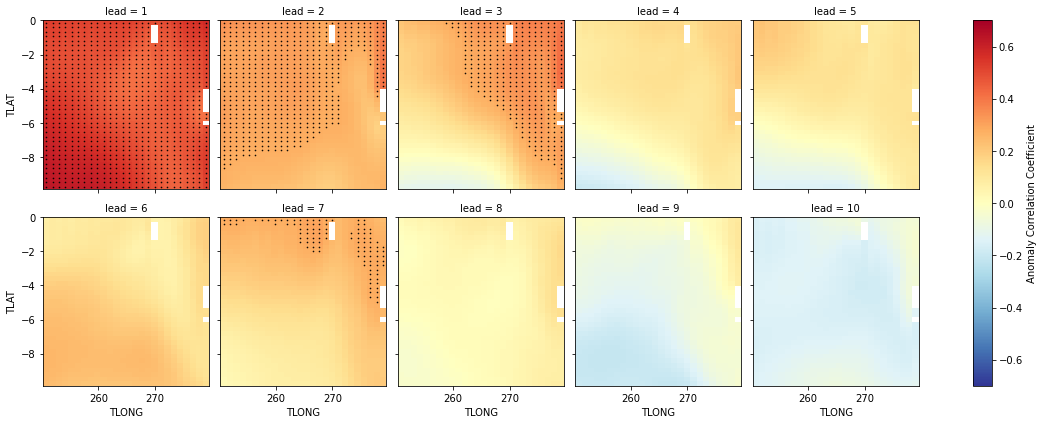

<IPython.core.display.Javascript object>

In [12]:
p = predictability.SST.plot.pcolormesh(
    x="TLONG",
    y="TLAT",
    col="lead",
    col_wrap=5,
    cbar_kwargs={"label": "Anomaly Correlation Coefficient"},
    vmin=-0.7,
    vmax=0.7,
    cmap="RdYlBu_r",
)
for i, ax in enumerate(p.axes.flat):
    # Add significance stippling
    ax.scatter(
        siglon.isel(lead=i), siglat.isel(lead=i), color="k", marker=".", s=1.5,
    )

## Root Mean Square Error of SSTs

We can also check error in our forecasts, just by changing the metric keyword to {py:func}`~climpred.metrics._rmse` or {py:func}`~climpred.metrics._mae`.

In [13]:
rmse = hindcast_detrend.verify(
    metric="rmse", comparison="e2o", dim="init", alignment="same_verif"
)

<IPython.core.display.Javascript object>

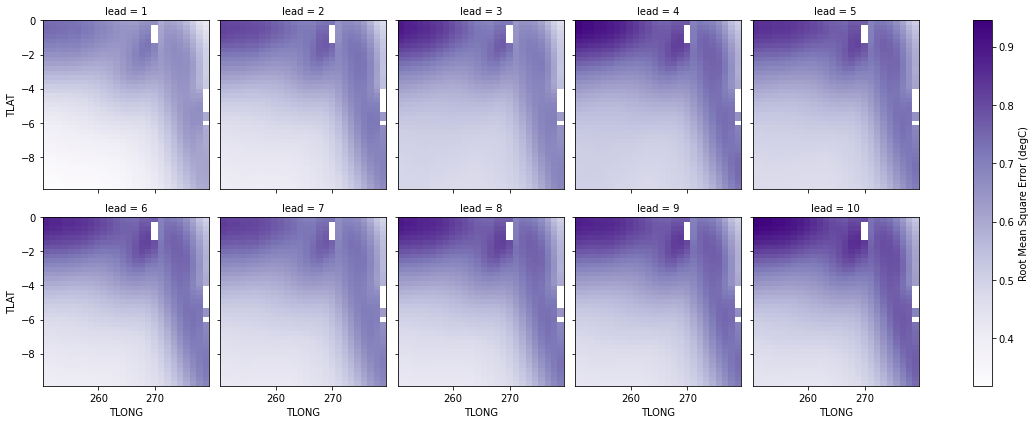

<IPython.core.display.Javascript object>

In [14]:
p = rmse.SST.plot.pcolormesh(
    x="TLONG",
    y="TLAT",
    col="lead",
    col_wrap=5,
    cbar_kwargs={"label": "Root Mean Square Error (degC)"},
    cmap="Purples",
)